<a href="https://colab.research.google.com/github/Ashishbhaskaranpillai/supply_chain_analytics/blob/main/Supply_Chain_Analytics_Project_Final_(_Workforce_Optimization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization and importing packages

In [ ]:
pip install pyworkforce

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn import *
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings
from pyworkforce.queuing import ErlangC
from pyworkforce.queuing import MultiErlangC
warnings.filterwarnings('ignore')
from google.colab import files

# Descriptive:Data cleaning&preprocessing

In [ ]:
# Load data file with #daily records from csv file into a Pandas dataframe
alloprof = pd.read_csv('https://raw.githubusercontent.com/Ashishbhaskaranpillai/supply_chain_analytics/main/Data/history_communications.csv')
# Load detail data file with time of the day from csv file into a Pandas dataframe
alloprof_detail = pd.read_csv('https://raw.githubusercontent.com/Ashishbhaskaranpillai/supply_chain_analytics/main/Data/details_communications.csv')

# Check the data types of each column
print(alloprof.dtypes)
print(alloprof_detail.dtypes)

# Check for any missing or invalid values in each column
print(alloprof.isnull().sum())
print(alloprof_detail.isnull().sum())

clean_prof = alloprof.copy()
prof_detail = alloprof_detail.copy()

Date            object
Service         object
Direction       object
Langue          object
Record_count     int64
dtype: object
Conversation_ID     object
Date                object
Time                object
Agent               object
Service             object
Direction           object
Langue              object
Niveau              object
Matiere             object
temps_comm           int64
temps_attente      float64
dtype: object
Date            0
Service         0
Direction       0
Langue          0
Record_count    0
dtype: int64
Conversation_ID        2
Date                   0
Time                   0
Agent                  0
Service                0
Direction              0
Langue                 0
Niveau             24925
Matiere            18392
temps_comm             0
temps_attente       5111
dtype: int64


In [ ]:
# Convert "Date" column to datetime format
clean_prof['Date'] = pd.to_datetime(clean_prof['Date'], dayfirst=True)
prof_detail['Date'] = pd.to_datetime(alloprof_detail['Date'], dayfirst=True)

# Clean the data by removing observations with a prior date to 2018-01-01 in the "Date" column
clean_prof = clean_prof[(clean_prof['Date'] >= '01-01-2018') & (clean_prof['Date'] <= '23-02-2023')].reset_index(drop=True)

# Clean the data by replacing any missing values with 'N/A'
prof_detail['temps_attente'] = prof_detail['temps_attente'].fillna(0)
prof_detail = prof_detail.fillna('N/A')

print(clean_prof.head())
print(prof_detail.head())
print(prof_detail.isnull().sum())

        Date Service Direction Langue  Record_count
0 2018-01-08    Call    direct     fr            70
1 2018-01-08    Chat    direct     fr            27
2 2018-01-08     SMS    direct     fr           218
3 2018-01-09    Call    direct     fr           184
4 2018-01-09    Chat    direct     fr            22
                        Conversation_ID       Date   Time  \
0  c3cba6ca-fe7b-500f-868d-de736d1abcc6 2021-03-10  15:48   
1  4a5d8a5b-a96a-57a2-a8a6-d541ad63d0d9 2021-03-10  15:56   
2  218c1480-e771-5f0d-97e1-d9be0b9ff70e 2021-03-10  16:05   
3  ac877e0f-e353-5214-89ef-a201839b02bb 2021-03-10  17:08   
4  91a857fc-8270-54aa-bbae-4561ec525159 2021-03-10  16:41   

                          Agent Service Direction Langue Niveau Matiere  \
0  J64XARaywiYGL8DlQ6dk76Or11g=     SMS    direct     fr    N/A     N/A   
1  J64XARaywiYGL8DlQ6dk76Or11g=    Call    direct     fr    N/A     N/A   
2  J64XARaywiYGL8DlQ6dk76Or11g=    Chat    direct     fr    N/A     N/A   
3  wdBCW8WvNcew3ZNHhA

In [ ]:
clean_prof_grouped=clean_prof.groupby('Date').sum()

In [ ]:
new_idx=pd.date_range('01-01-2018', '23-02-2023')
clean_prof_grouped=clean_prof_grouped.reindex(new_idx).fillna(0)
clean_prof_grouped.index.name='Date'
pd.to_datetime(clean_prof_grouped.index)
clean_prof_grouped.sort_index(inplace=True)

##Yearly Total Requests

        sum
Date       
2018  54172
2019  50923
2020  48074
2021  35166
2022  45408


Text(0, 0.5, 'Request sums')

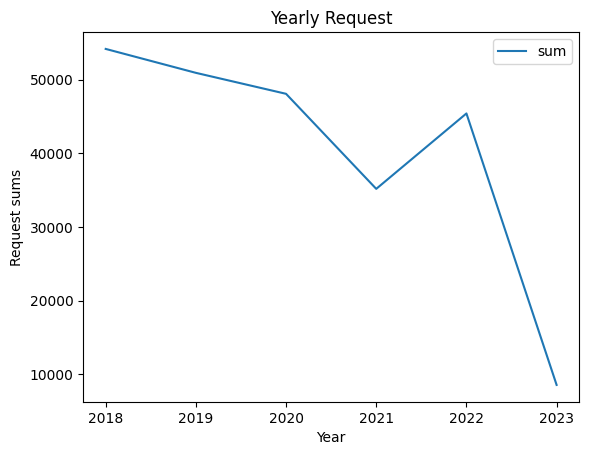

In [ ]:
# Aggregate data into annual sums
yearly_sums = clean_prof.groupby(clean_prof['Date'].dt.year)['Record_count'].agg(['sum'])

# Create a line chart of the annual sums
yearly_sums.plot(kind='line', title='Yearly Request')
print(yearly_sums.head())

# Ajoute des étiquettes d'axe
plt.xlabel('Year')
plt.ylabel('Request sums')

##Weekly Average Requests in the Year

Date
1    38.384615
2    65.414141
3    83.184466
4    75.990909
5    80.142857
Name: Record_count, dtype: float64


(1.0, 52.0)

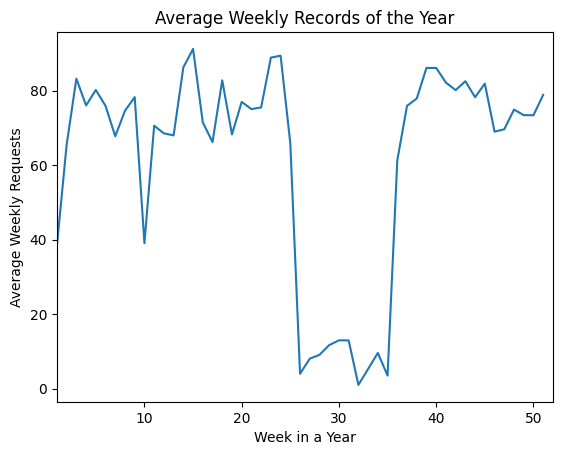

In [ ]:
# Group the data by week of the year and calculate the mean for each group
weekly_mean = clean_prof.groupby(clean_prof['Date'].dt.weekofyear)['Record_count'].mean()

# Create a line plot of the mean for each week of the year
weekly_mean.plot(kind='line', title='Average Weekly Records of the Year')
print(weekly_mean.head())
# Add axis labels
plt.xlabel('Week in a Year')
plt.ylabel('Average Weekly Requests')

# Set the x-axis limits to 1 and 51
plt.xlim(1, 52)

##Daily Average Requests in the Week

Date
0    95.222826
1    79.432584
2    77.036568
3    61.150862
4    25.670588
Name: Record_count, dtype: float64


([<matplotlib.axis.XTick at 0x7f6968a43b50>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

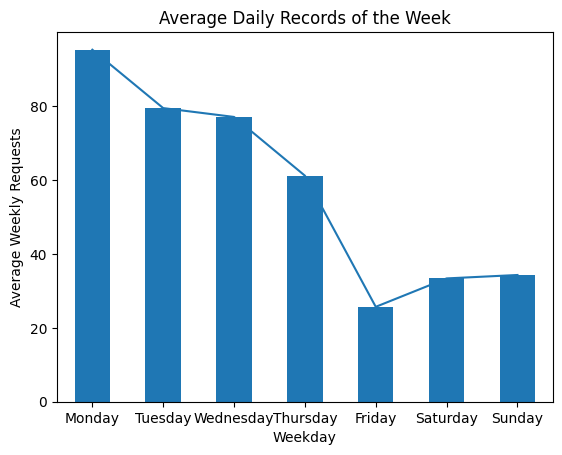

In [ ]:
# Group the data by weekday and calculate the mean for each group
weekday_mean = clean_prof.groupby(clean_prof['Date'].dt.dayofweek)['Record_count'].mean()

# Create a bar chart of the mean for each weekday
weekday_mean.plot(kind='bar', title='Average Daily Records of the Week')
weekday_mean.plot(kind='line', title='Average Daily Records of the Week')

# Add axis labels
plt.xlabel('Weekday')
plt.ylabel('Average Weekly Requests')
print(weekday_mean.head())

# Set the x-tick labels to the weekday names
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


##Hourly Average Requests in the Day

object
Time
0        25
1        52
2        28
3        25
4        61
5        59
6       182
7       203
8       195
9      2527
10     3829
11     3485
12     3653
13    18666
14    21455
15    23218
16      409
17       45
18       61
19       90
20       71
21       63
22       58
23       44
Name: Conversation_ID, dtype: int64
Time
0    25.0
1    52.0
2    28.0
3    25.0
4    61.0
Name: Conversation_ID, dtype: float64


(0.0, 23.0)

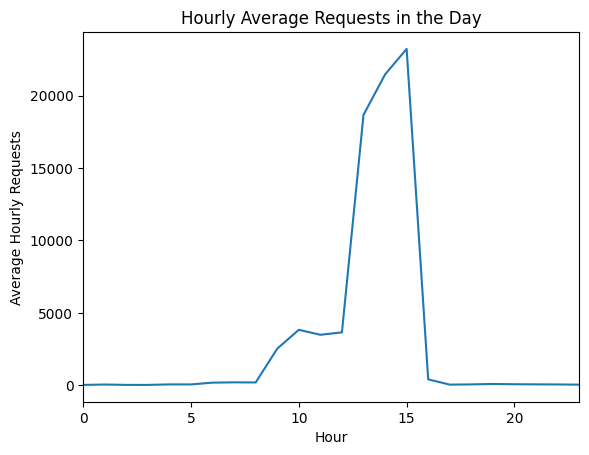

In [ ]:
#check date type in 'Time' column
print(prof_detail['Time'].dtypes)

# Transform the 'Time' column to the integer format with hour value keeping
prof_detail['Time'] = pd.to_datetime(prof_detail['Time'], format='%H:%M', errors='coerce')

# Calculate the hourly count for each hour of each day
hourly_count = prof_detail.groupby(prof_detail['Time'].dt.hour)['Conversation_ID'].count()
print(hourly_count)

# Calculate the mean hourly count for each hour of the day
hourly_mean = hourly_count.groupby('Time').mean()

# Create a line plot of the mean for each hour
hourly_mean.plot(kind='line', title='Hourly Average Requests in the Day')
print(hourly_mean.head())
# Add axis labels
plt.xlabel('Hour')
plt.ylabel('Average Hourly Requests')

# Set the x-axis limits to 0 and 23
plt.xlim(0, 23)


## Communication Mode Analysis

In [ ]:
subject_requests = alloprof_detail.groupby(alloprof_detail['Matiere'])['Conversation_ID'].count()
langue_requests=alloprof_detail.groupby(alloprof_detail['Langue'])['Conversation_ID'].count()

In [ ]:
# Clean the data by deleting "_","autre","null_null"
alloprof_detail = alloprof_detail.dropna()
subject_requests = subject_requests.drop(
   labels=['autre','_','null_null'],
   axis=0,
   inplace=False
)
subject_requests

Matiere
anglais                  1388
chimie                   1358
education_financiere      555
francais                 8111
geo_histoire              897
geographie                503
histoire                 2098
math                    17477
math_1_2                 3725
math_3_5                 7572
monde_contemporain        408
physique                 1364
sciences                11647
Name: Conversation_ID, dtype: int64

Text(0, 0.5, 'Request sums')

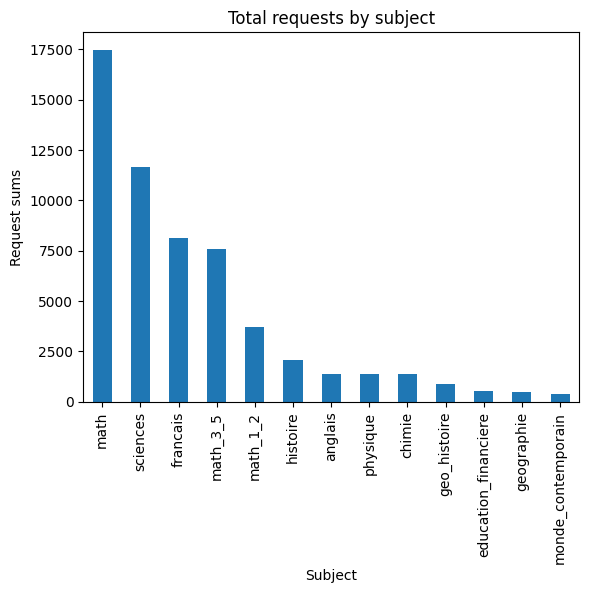

In [ ]:
## Create a bar plot of the sum of total requests
subject_requests.sort_values(ascending=False).plot(kind='bar', title='Total requests by subject')
plt.rcParams['figure.figsize'] = [40,10]

# add labels
plt.xlabel('Subject')
plt.ylabel('Request sums')

In [ ]:
# Aggregate data into mode of communications
mode_requests = alloprof_detail.groupby(alloprof_detail['Service'])['Matiere'].count()

mode_requests

Service
Call    21196
Chat    27996
SMS      2091
Name: Matiere, dtype: int64

Text(0, 0.5, 'Total Request')

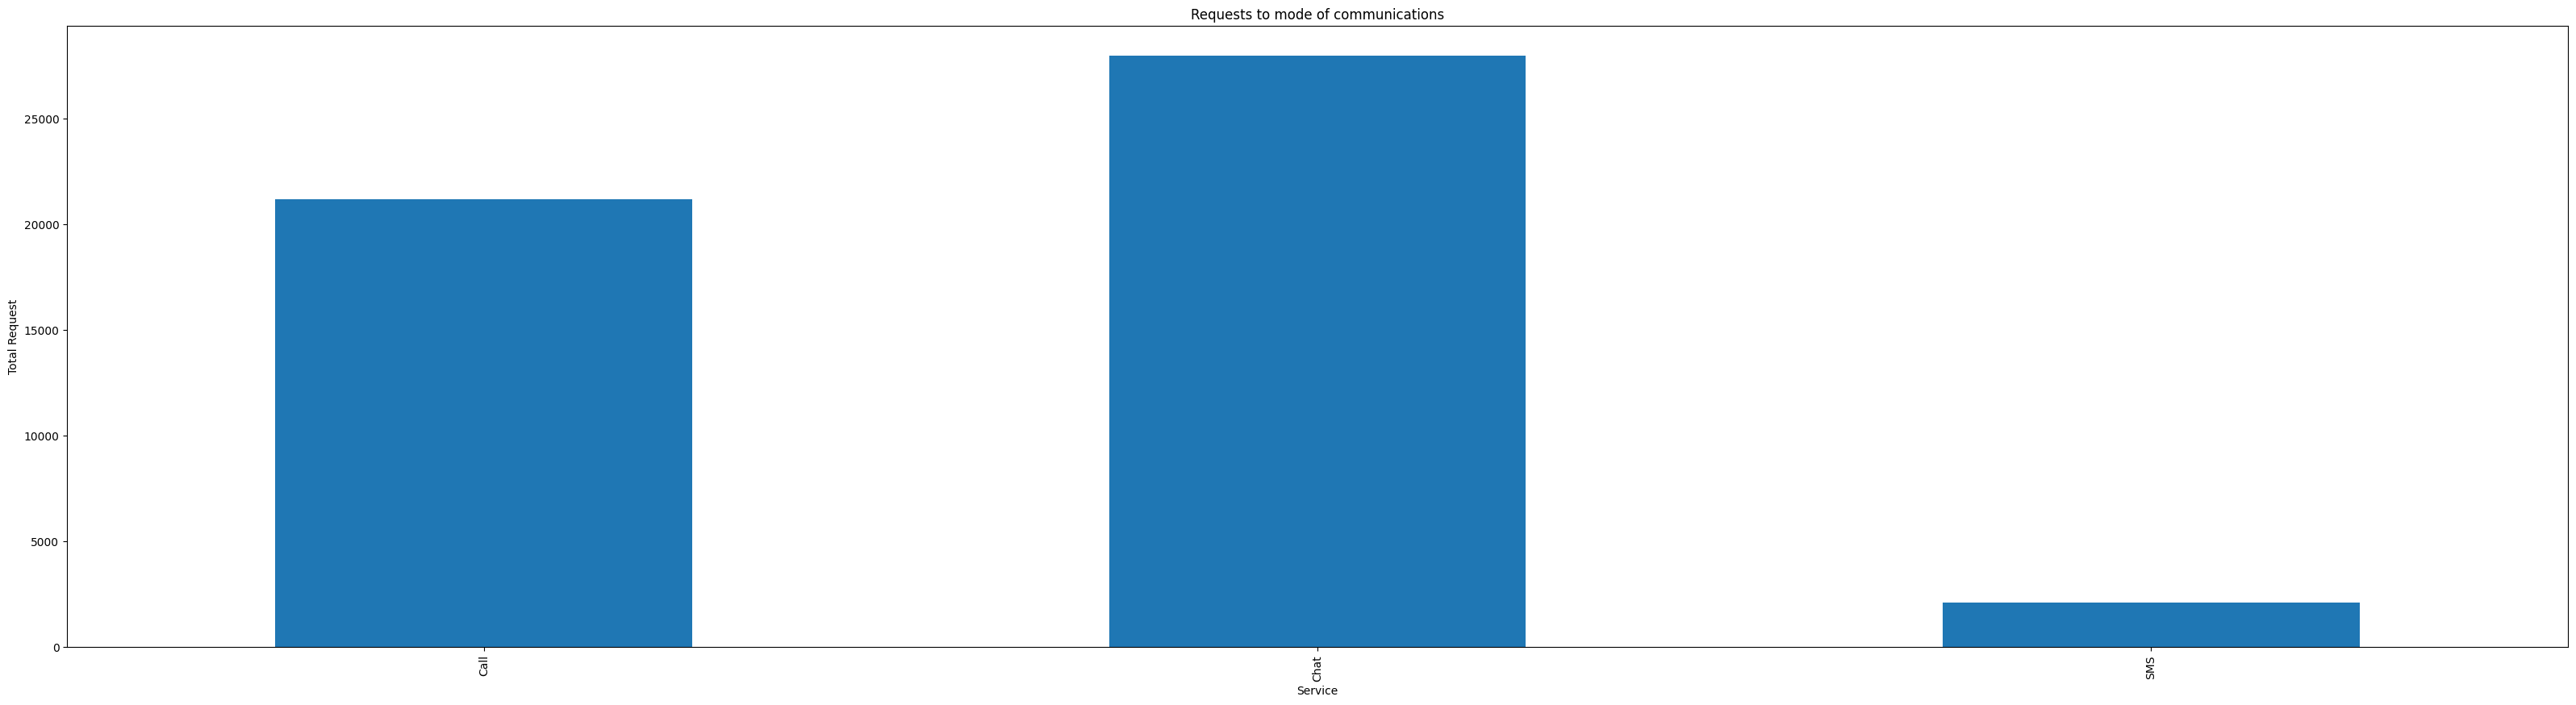

In [ ]:
# Create a bar chart
mode_requests.plot(kind='bar', title='Requests to mode of communications',)
plt.rcParams['figure.figsize'] = [5,5]

# add labels
plt.xlabel('Service')
plt.ylabel('Total Request')

In [ ]:
#average call time and wait time in total
mode_temps=alloprof_detail.groupby(alloprof_detail['Service'])['temps_comm','temps_attente'].mean()
mode_temps

,temps_comm,temps_attente
Service,,
Call,670.891772,44.796188
Chat,1580.879519,91.991606
SMS,1803.182209,31.130560


Text(0, 0.5, 'Time')

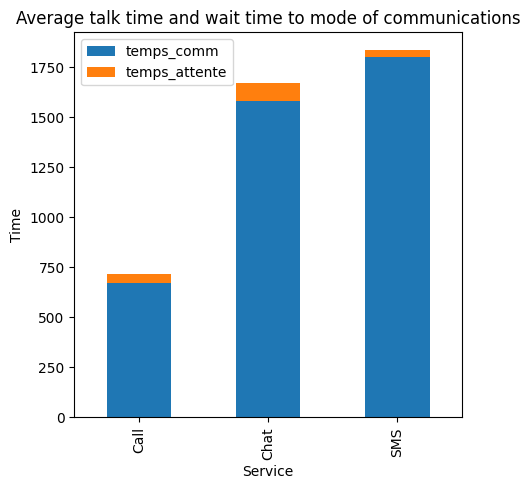

In [ ]:
# Create a bar chart
mode_temps.plot(kind='bar', y =['temps_comm','temps_attente'], title='Average talk time and wait time to mode of communications', stacked=True)
#add labels
plt.xlabel('Service')
plt.ylabel('Time')

## Call and wait time by subjects

In [ ]:
# Clean the data by choosing data call mode in the "Service" column
alloprof_detailCall = alloprof_detail[(alloprof_detail['Service'] == 'Call') & (alloprof_detail['Matiere'] != '0')]
alloprof_detailCall['temps_attente'] = pd.to_numeric(alloprof_detailCall['temps_attente'])

# Aggregate data into subject sums
subject_callTime = alloprof_detailCall.groupby(by='Matiere')['temps_comm', 'temps_attente'].sum()

In [ ]:
alloprof_detailCall['temps_attente'] = pd.to_numeric(alloprof_detailCall['temps_attente'])

# Aggregate data into subject sums
subject_callTime = alloprof_detailCall.groupby(by='Matiere')['temps_comm', 'temps_attente'].sum()

In [ ]:
subject_callTimeCo1 = alloprof_detailCall.groupby(by='Matiere')['temps_comm'].mean()/60
subject_callTime['avg_comm'] = subject_callTimeCo1
subject_callTimeCo2 = alloprof_detailCall.groupby(by='Matiere')['temps_attente'].mean()/60
subject_callTime['avg_attente'] = subject_callTimeCo2

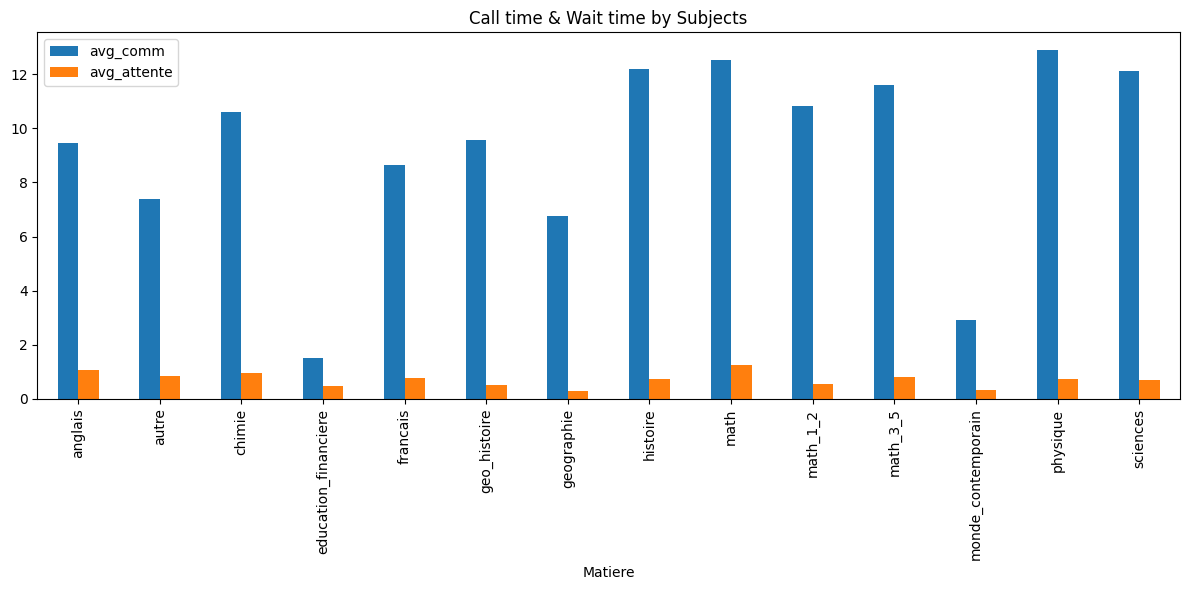

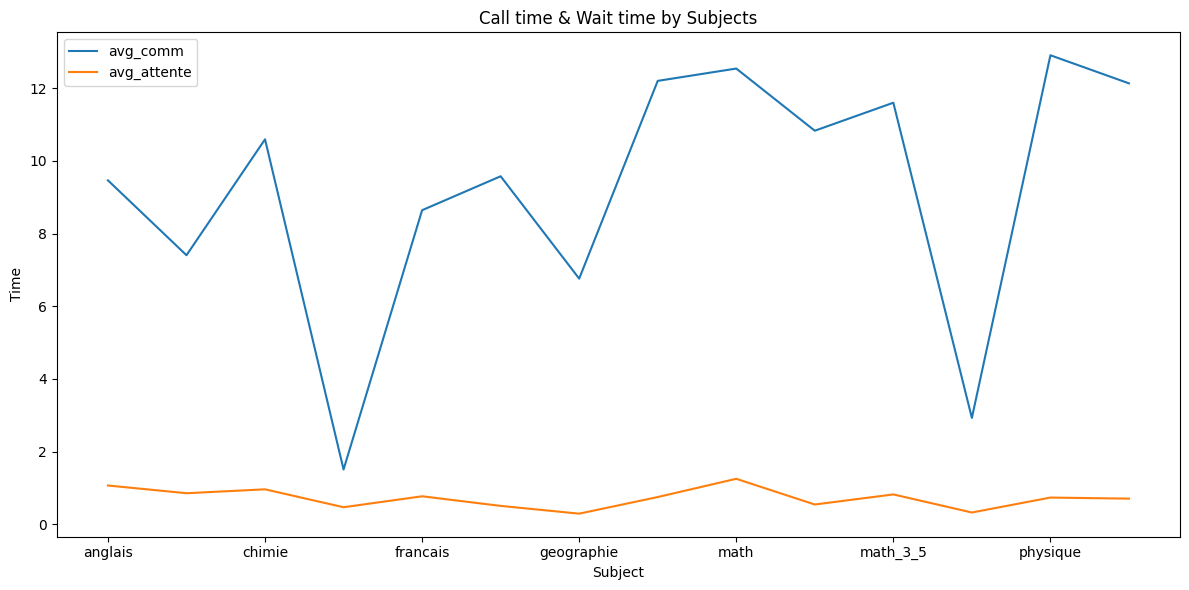

In [ ]:
## Create a plot
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams['figure.autolayout'] = True

subject_callTime.plot(kind='bar', y =['avg_comm',"avg_attente"], title='Call time & Wait time by Subjects')
subject_callTime.plot(kind='line', y =['avg_comm',"avg_attente"], title='Call time & Wait time by Subjects')


# add labels
plt.xlabel('Subject')
plt.ylabel('Time')

plt.show()

# Feature engineering

## Feature preparation

In [ ]:
# Feature creation for datetime elements
clean_prof_grouped['day_of_week'] = clean_prof_grouped.index.dayofweek
clean_prof_grouped['month'] = clean_prof_grouped.index.month
clean_prof_grouped['year'] = clean_prof_grouped.index.year
clean_prof_grouped['day'] = clean_prof_grouped.index.day
clean_prof_grouped['holiday'] = clean_prof_grouped['day_of_week'].apply(lambda x: 1 if (x==4 or x==5) else 0)

In [ ]:
# Dummy variable creation
categorical_columns = ['day_of_week', 'month', 'year','day']
for col in categorical_columns:
  dummy = pd.get_dummies(clean_prof_grouped[col], prefix=col)
  clean_prof_grouped = pd.concat([clean_prof_grouped.drop(columns=col), dummy], axis=1)

In [ ]:
# Feature list creation
features = list(clean_prof_grouped.columns)
features.remove('Record_count')

In [ ]:
features

['holiday',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'year_2018',
 'year_2019',
 'year_2020',
 'year_2021',
 'year_2022',
 'year_2023',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_30',
 'day_31']

## Cross Validation split

In [ ]:
# Train and test split based on fixed dates : Last 2 weeks = Test data
train, test = clean_prof_grouped.loc[clean_prof_grouped.index<='2023-02-09'], clean_prof_grouped.loc[(clean_prof_grouped.index>='2023-02-10')]
X_train=train.copy()[features]
X_test=test.copy()[features]
y_train=train.pop('Record_count').astype('float')
y_test=test.pop('Record_count').astype('float')

# Error Functions

In [ ]:
# MAPE function
def mape(actual, pred):
  val = np.abs(actual-pred)/actual
  val[val == np.inf] = np.nan
  val = np.nanmean(val)
  return np.round(val*100, 2)

In [ ]:
# Forecast bias function
def bias(actual, pred):
  val = pred/actual
  val[val == np.inf] = np.nan
  val = np.nanmean(val)
  return np.round(val*100, 2)

# Multicollinearity Check

In [ ]:
# Creating a dubplicate DF to check multicollinearity
cpg=clean_prof.groupby('Date').sum()

In [ ]:
cpg['day_of_week'] = cpg.index.dayofweek
cpg['month'] = cpg.index.month
cpg['year'] = cpg.index.year
cpg['day'] = cpg.index.day
cpg['holiday'] = cpg['day_of_week'].apply(lambda x: 1 if (x==4 or x==5) else 0)

In [ ]:
categorical_columns = ['day_of_week', 'month', 'year','day']
for col in categorical_columns:
  dummy = pd.get_dummies(cpg[col], prefix=col,drop_first=True)
  cpg = pd.concat([cpg.drop(columns=col), dummy], axis=1)

In [ ]:
vif_features=features.copy()

In [ ]:
vif_features.remove('day_of_week_0')
vif_features.remove('month_1')
vif_features.remove('year_2018')
vif_features.remove('day_1')

In [ ]:
vif_train, vif_test = cpg.loc[cpg.index<='2023-02-09'], cpg.loc[(cpg.index>='2023-02-10')]
vif_X_train=vif_train.copy()[vif_features]
vif_X_test=vif_test.copy()[vif_features]
vif_y_train=vif_train.pop('Record_count').astype('float')
vif_y_test=vif_test.pop('Record_count').astype('float')

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = vif_X_train.columns

In [ ]:
# Generating the varince inflation factor (VIF)
vif_data["VIF"] = [variance_inflation_factor(vif_X_train.values, i)
                          for i in range(len(vif_X_train.columns))]
print(vif_data)

          feature       VIF
0         holiday       inf
1   day_of_week_1  1.942981
2   day_of_week_2  1.953650
3   day_of_week_3  1.938509
4   day_of_week_4       inf
5   day_of_week_5       inf
6   day_of_week_6  1.485913
7         month_2  1.819277
8         month_3  1.748480
9         month_4  1.805793
10        month_5  1.823226
11        month_6  1.634654
12        month_7  1.613115
13        month_8  1.146529
14        month_9  1.770796
15       month_10  1.816868
16       month_11  1.846895
17       month_12  1.614788
18      year_2019  1.842878
19      year_2020  1.831375
20      year_2021  2.217081
21      year_2022  2.078154
22      year_2023  1.198982
23          day_2  1.404203
24          day_3  1.321106
25          day_4  1.397304
26          day_5  1.415531
27          day_6  1.418268
28          day_7  1.372723
29          day_8  1.389679
30          day_9  1.401526
31         day_10  1.355388
32         day_11  1.363046
33         day_12  1.408436
34         day_13  1

# Holt Winters

In [ ]:
# Hyper parameter tuning using a parameter grid and for loop as GridsearchCV was generating an error
parameter_grid_hw = {
    'seasonal_periods': [52],
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'use_boxcox': [True, False],
    'initialization_method': [None, 'estimated', 'heuristic', 'legacy-heuristic']
}

best_config = {}
best_rmse = 10000000000

model_HW = ExponentialSmoothing(y_train)
for trend in parameter_grid_hw['trend']:
  for seasonal in parameter_grid_hw['seasonal']:
    for use_boxcox in parameter_grid_hw['use_boxcox']:
      for initialization_method in parameter_grid_hw['initialization_method']:
        model_HW = ExponentialSmoothing(y_train.replace(0, 0.0000001).values, trend=trend, seasonal=seasonal, seasonal_periods=52, use_boxcox=use_boxcox, initialization_method=initialization_method).fit()
        prediction = model_HW.forecast(len(y_train))
        prediction[np.isnan(prediction)] = 0
        if mean_squared_error(y_train.values, prediction, squared=False) < best_rmse:
          best_rmse = mean_squared_error(y_train, prediction, squared=False)
          best_config['trend'] = trend
          best_config['seasonal'] = seasonal
          best_config['seasonal_periods'] = 52
          best_config['use_boxcox'] = use_boxcox
          best_config['initialization_method'] = initialization_method

In [ ]:
list(best_config.values())

['mul', 'add', 52, False, None]

In [ ]:
# model fitting and predicting
best_model_hw = ExponentialSmoothing(y_train.replace(0, 0.000001).values,
                                  seasonal_periods = best_config['seasonal_periods'],
                                  trend = best_config['trend'],
                                  seasonal = best_config['seasonal'],
                                  use_boxcox = best_config['use_boxcox'],
                                  initialization_method = best_config['initialization_method']).fit()
prediction_hw = best_model_hw.forecast(14)

Text(0, 0.5, 'Predicted requests')

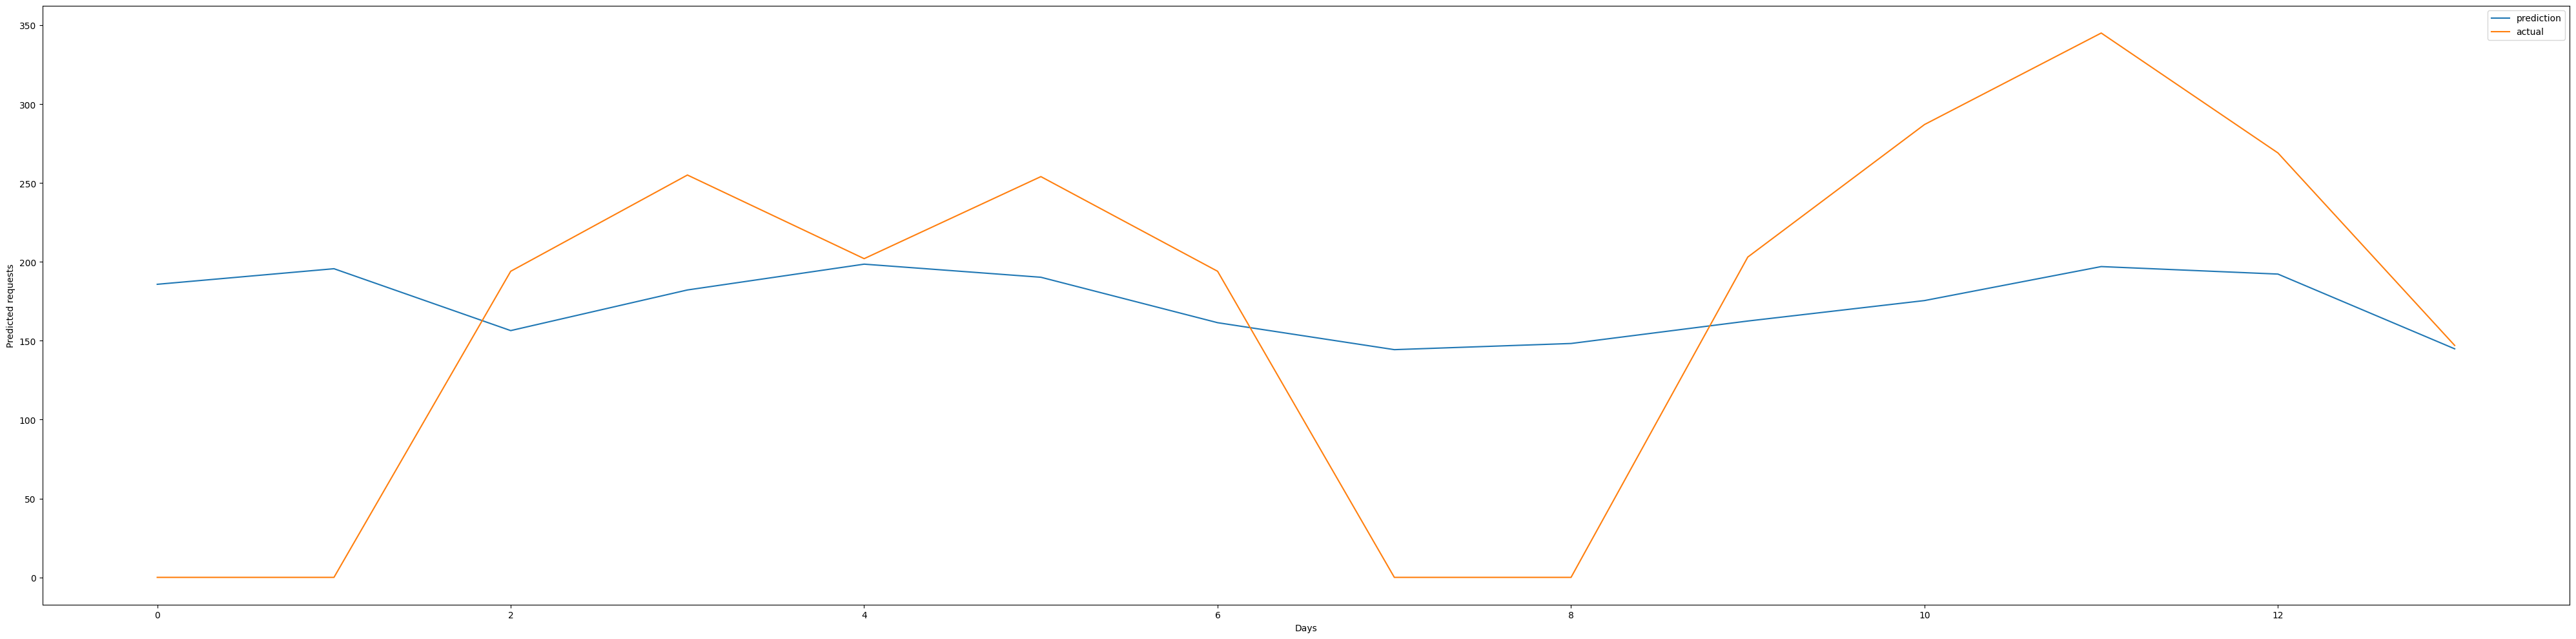

In [ ]:
# model output plot
plt.figure(figsize=(40,10))
plt.plot(prediction_hw)
plt.plot(y_test.values)
plt.legend(['prediction', 'actual'])
plt.xlabel('Days')
plt.ylabel('Predicted requests')

In [ ]:
# rmse
mean_squared_error(y_test.values, prediction_hw, squared=False)

109.97948511923074

In [ ]:
best_model_hw.params

{'smoothing_level': 0.07571428571428572,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.13693121693121693,
 'damping_trend': nan,
 'initial_level': 111.50000041666665,
 'initial_trend': 0.9974455847070844,
 'initial_seasons': array([-111.49999942, -111.49999942, -111.49999942, -111.49999942,
        -111.49999942, -111.49999942, -111.49999942,  203.49999958,
          94.49999958,  155.49999958,  167.49999958,  -85.50000042,
        -111.49999942, -111.49999942,  445.49999958,  194.49999958,
         193.49999958,  189.49999958,  -73.50000042, -111.49999942,
        -111.49999942,  421.49999958,  157.49999958,  161.49999958,
         113.49999958,  -95.50000042, -111.49999942, -111.49999942,
         467.49999958,  230.49999958,  190.49999958,  130.49999958,
         -64.50000042, -111.49999942, -111.49999942,  420.49999958,
         166.49999958,  185.49999958,  113.49999958,  -82.50000042,
        -111.49999942, -111.49999942,  320.49999958,  197.49999958,
         158.49999958

# Random Forest Model

In [ ]:
# Hyper parameter tuning using GridSearchCV and model fitting
parameter_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_rs = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_rs, param_grid=parameter_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Best parameters: ", grid_search_rf.best_params_)

Best parameters:  {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}


In [ ]:
# predicting the output
record_pred_rf = grid_search_rf.predict(X_test)

In [ ]:
result_rf = pd.concat([y_test.reset_index(), pd.Series(record_pred_rf, name='Predictions')], axis=1)
result_rf['Predictions'] = result_rf['Predictions'].apply(lambda x:math.floor(x))
result_rf.set_index('Date', inplace=True)
result_rf = pd.concat([test, result_rf], axis=1)

Text(0, 0.5, 'Predicted requests')

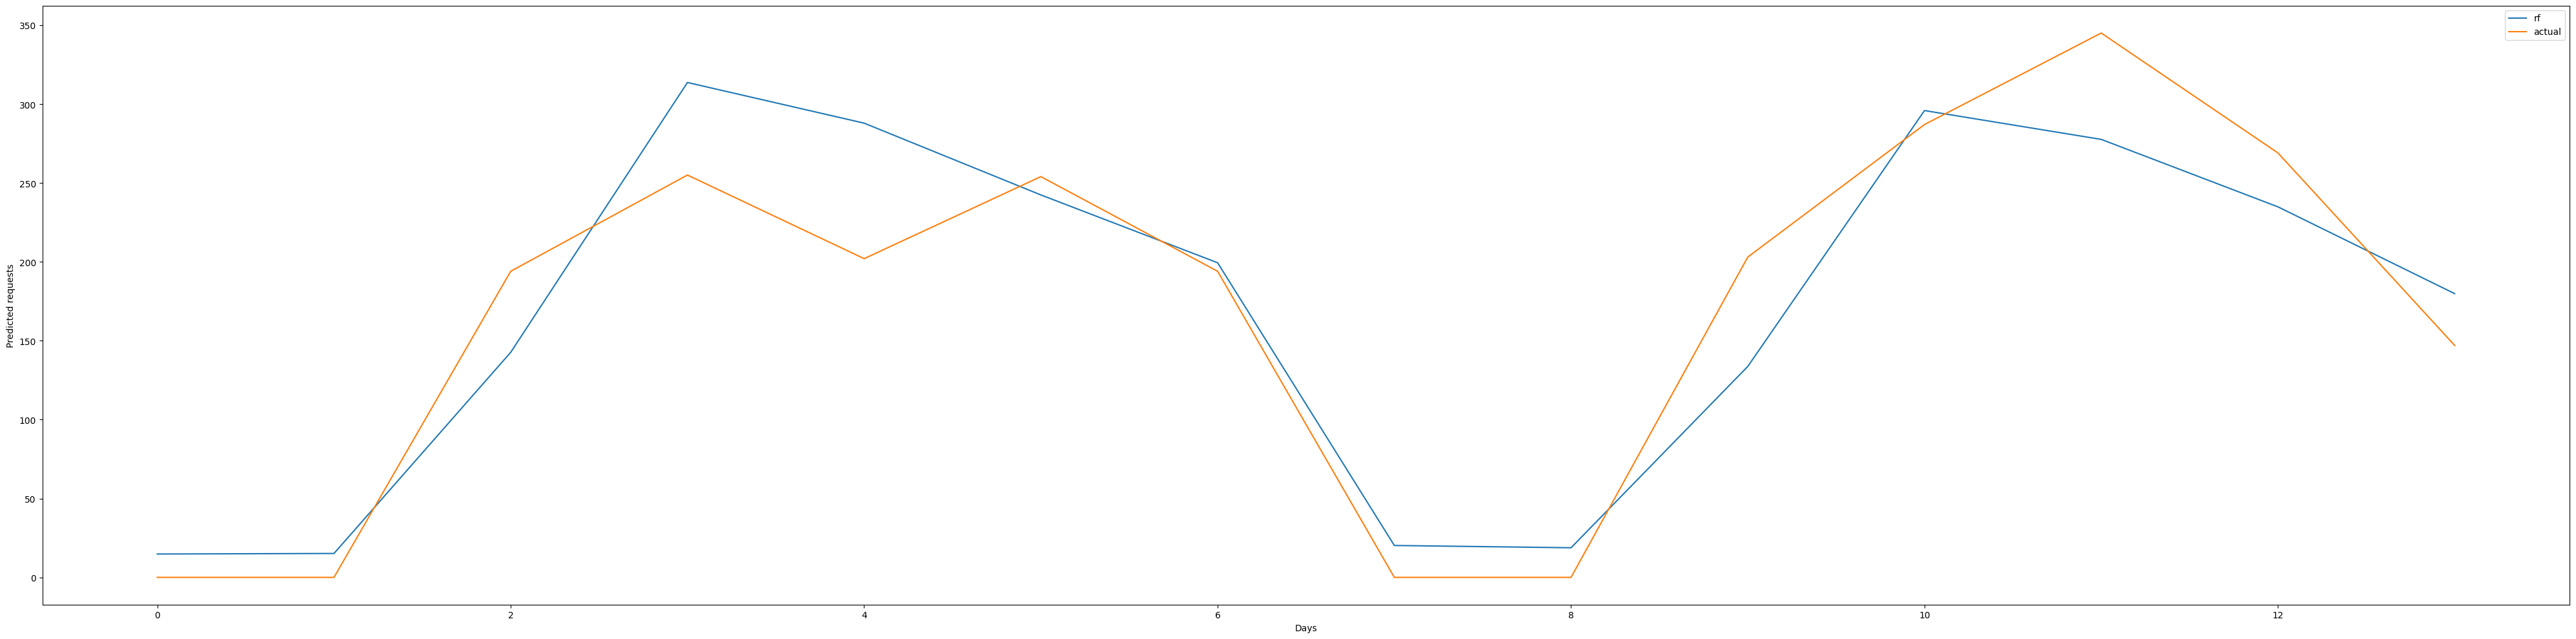

In [ ]:
# model output plot
plt.figure(figsize=(40,10))
plt.plot(record_pred_rf)
plt.plot(y_test.astype('float').values)
plt.legend(['rf', 'actual'])
plt.xlabel('Days')
plt.ylabel('Predicted requests')

In [ ]:
# rmse
print(mean_squared_error(y_test,record_pred_rf )**(1/2))

43.507286068788844


# Lasso Regression

In [ ]:
# Hyper parameter tuning using GridSearchCV and model fitting
parameter_grid_lr = {
    'alpha': list(np.linspace(1,2,100))
}
model_lr=Lasso()
grid_search_lr= GridSearchCV(model_lr, parameter_grid_lr, scoring='neg_mean_squared_error',cv=5)
grid_search_lr.fit(X_train, y_train)
print("Best parameters: ", grid_search_lr.best_params_)

Best parameters:  {'alpha': 1.0}


In [ ]:
# predicting and generating rmse
record_pred_lr = grid_search_lr.predict(X_test)
print(mean_squared_error(y_test,record_pred_lr )**(1/2))

60.48908328779334


Text(0, 0.5, 'Predicted requests')

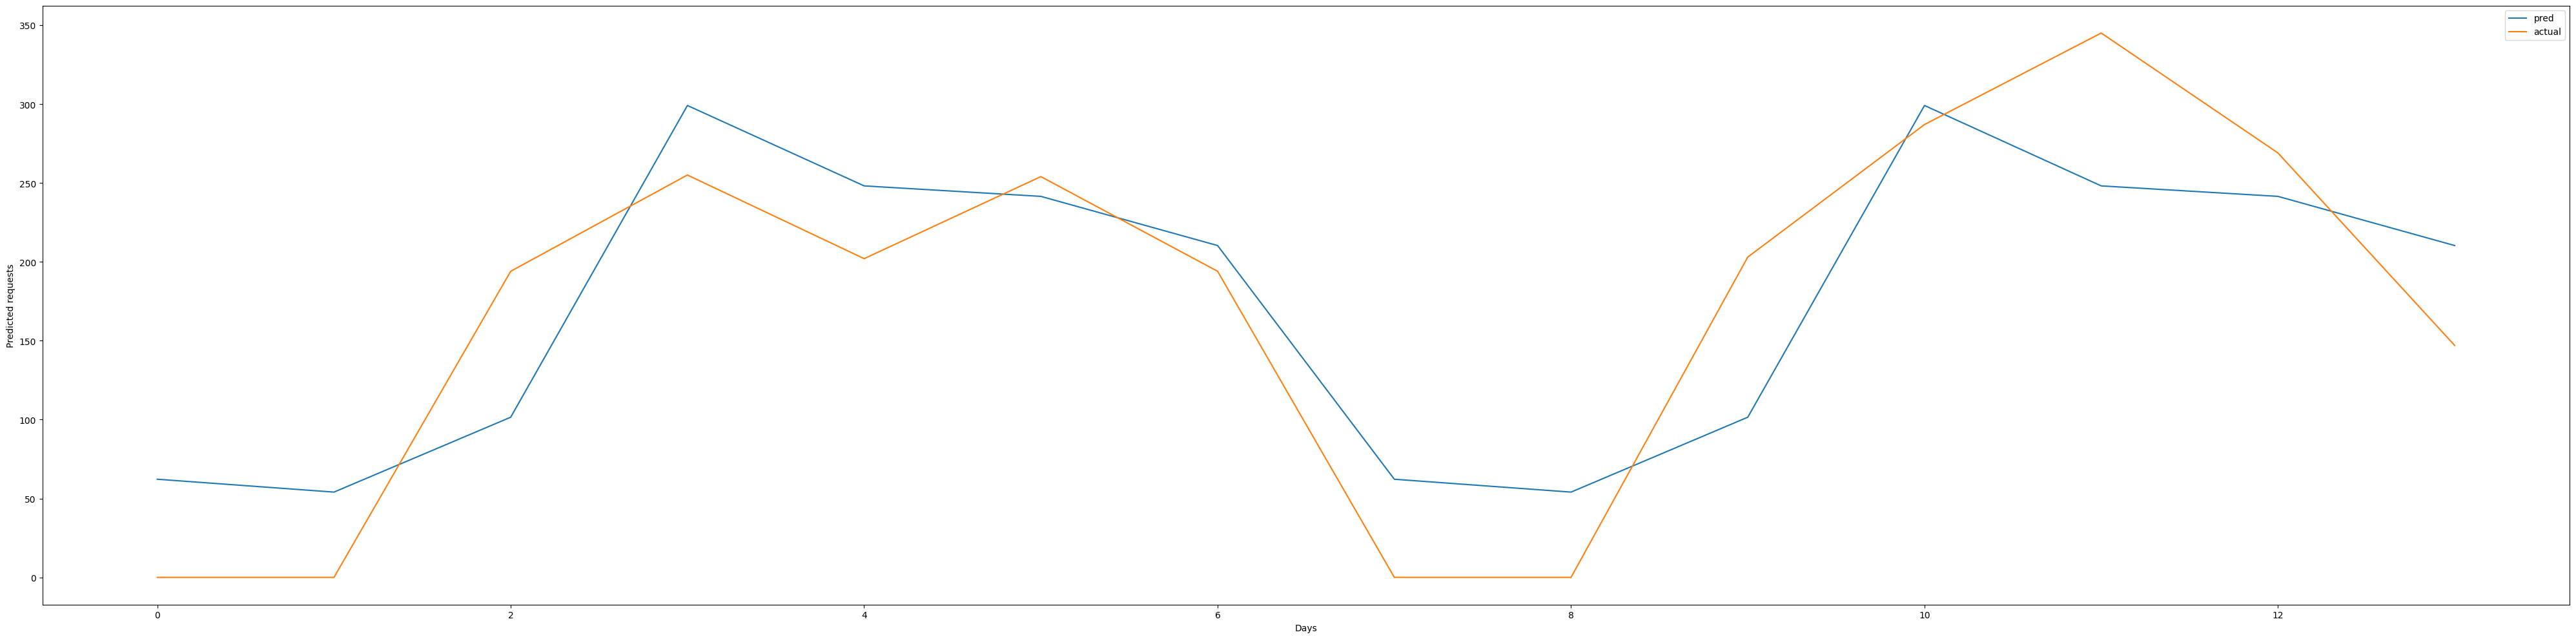

In [ ]:
# model output plot
plt.figure(figsize=(40,10))
plt.plot(record_pred_lr)
plt.plot(y_test.astype('float').values)
plt.legend(['pred', 'actual'])
plt.xlabel('Days')
plt.ylabel('Predicted requests')

# Rigde Regression

In [ ]:
# Hyper parameter tuning using GridSearchCV and model fitting
parameter_grid_rr= {
    'alpha': list(range(0,100,1))
}
model=Ridge()
grid_search_rr= GridSearchCV(model, parameter_grid_rr, scoring='neg_mean_squared_error',cv=5)
grid_search_rr.fit(X_train, y_train)
print("Best parameters: ", grid_search_rr.best_params_)

Best parameters:  {'alpha': 36}


In [ ]:
# predicting and generating rmse
record_pred_rr = grid_search_rr.predict(X_test)
print(mean_squared_error(y_test,record_pred_rr )**(1/2))

60.34790851446505


Text(0, 0.5, 'Predicted requests')

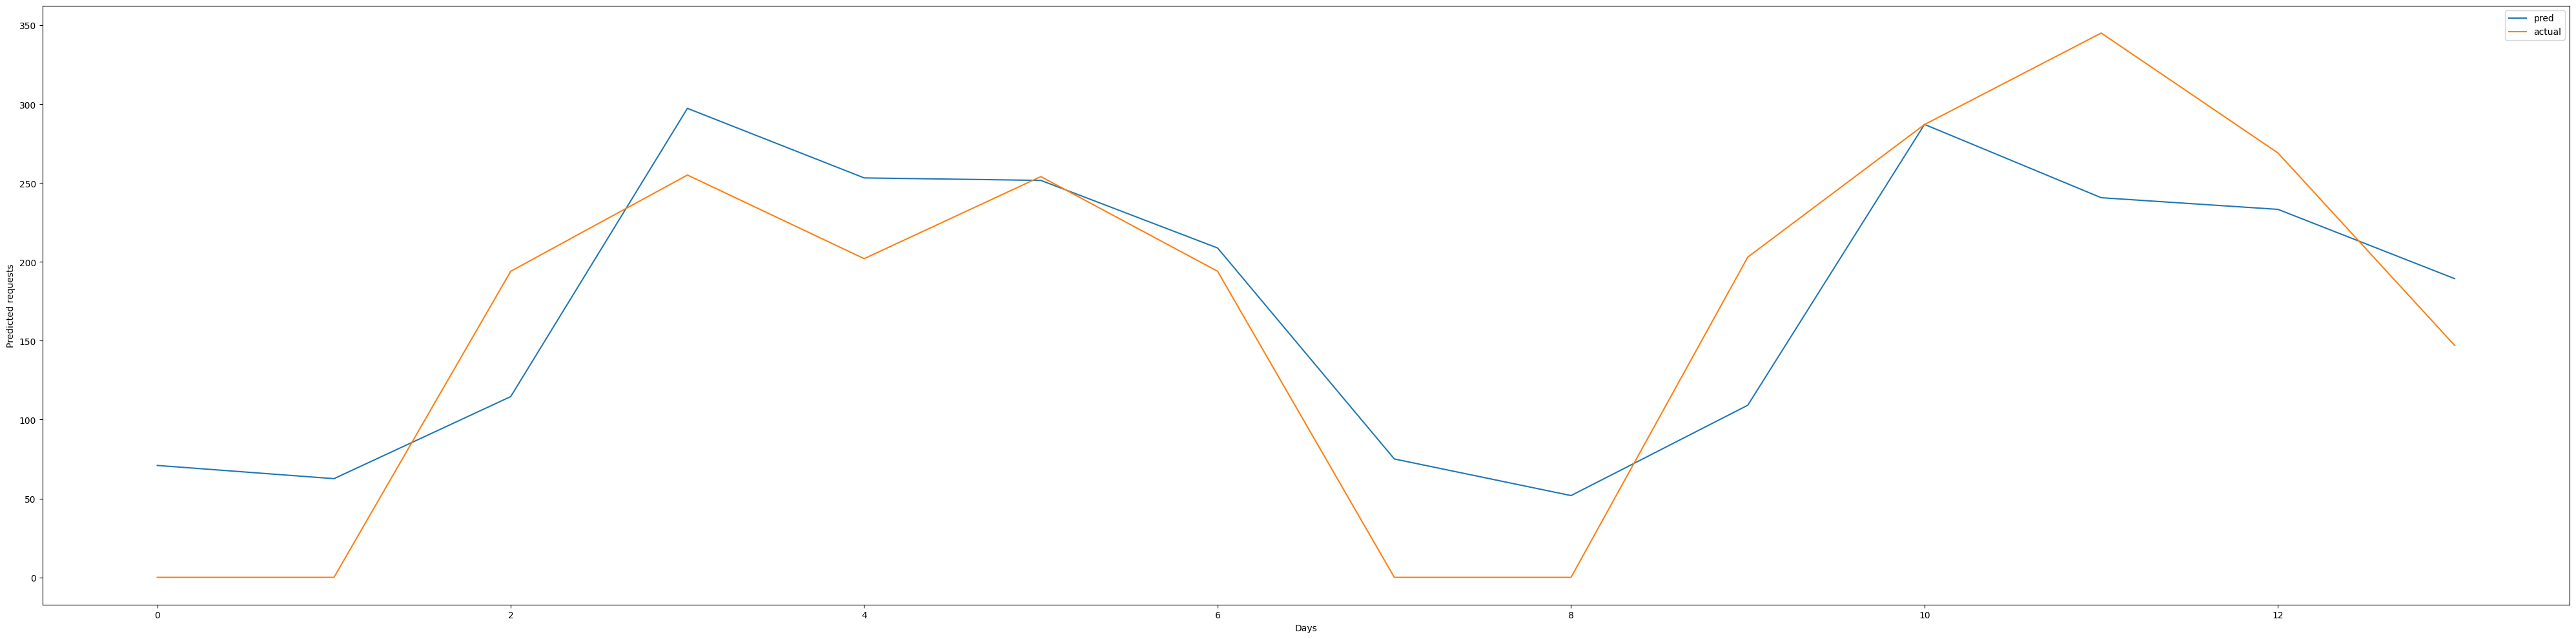

In [ ]:
# model output plot
plt.figure(figsize=(40,10))
plt.plot(record_pred_rr)
plt.plot(y_test.astype('float').values)
plt.legend(['pred', 'actual'])
plt.xlabel('Days')
plt.ylabel('Predicted requests')

# LightGBM

In [ ]:
# Hyper parameter tuning using GridSearchCV and model fitting
param_grid_lgbm = {
    'num_leaves': [30,50,80],
    'min_data_in_leaf': [10,20,30],
    'max_depth':[-1,10,20],
    'min_gain_to_split':[0,0.1,0.5,0.8],
    'max_bin':[50,100,255],
    'lambda_l1': [0,2,3,4],
    'lambda_l2': [0,0.5,1,2],
    'num_iterations':[20,50,80]
    }
lgbm_rs = LGBMRegressor(random_state=0)

grid_search_lgbm = GridSearchCV(estimator=lgbm_rs, param_grid=param_grid_lgbm, cv=5, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train,eval_metric='rmse')
print("Best parameters: ", grid_search_lgbm.best_params_)

[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Best parameters:  {'lambda_l1': 2, 'lambda_l2': 0, 'max_bin': 50, 'max_depth': -1, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.1, 'num_iterations': 80, 'num_leaves': 50}


In [ ]:
# predicting the output
record_pred_lgbm = grid_search_lgbm.predict(X_test)

In [ ]:
# rmse
print(mean_squared_error(y_test,record_pred_lgbm )**(1/2))

65.93431472793044


Text(0, 0.5, 'Predicted requests')

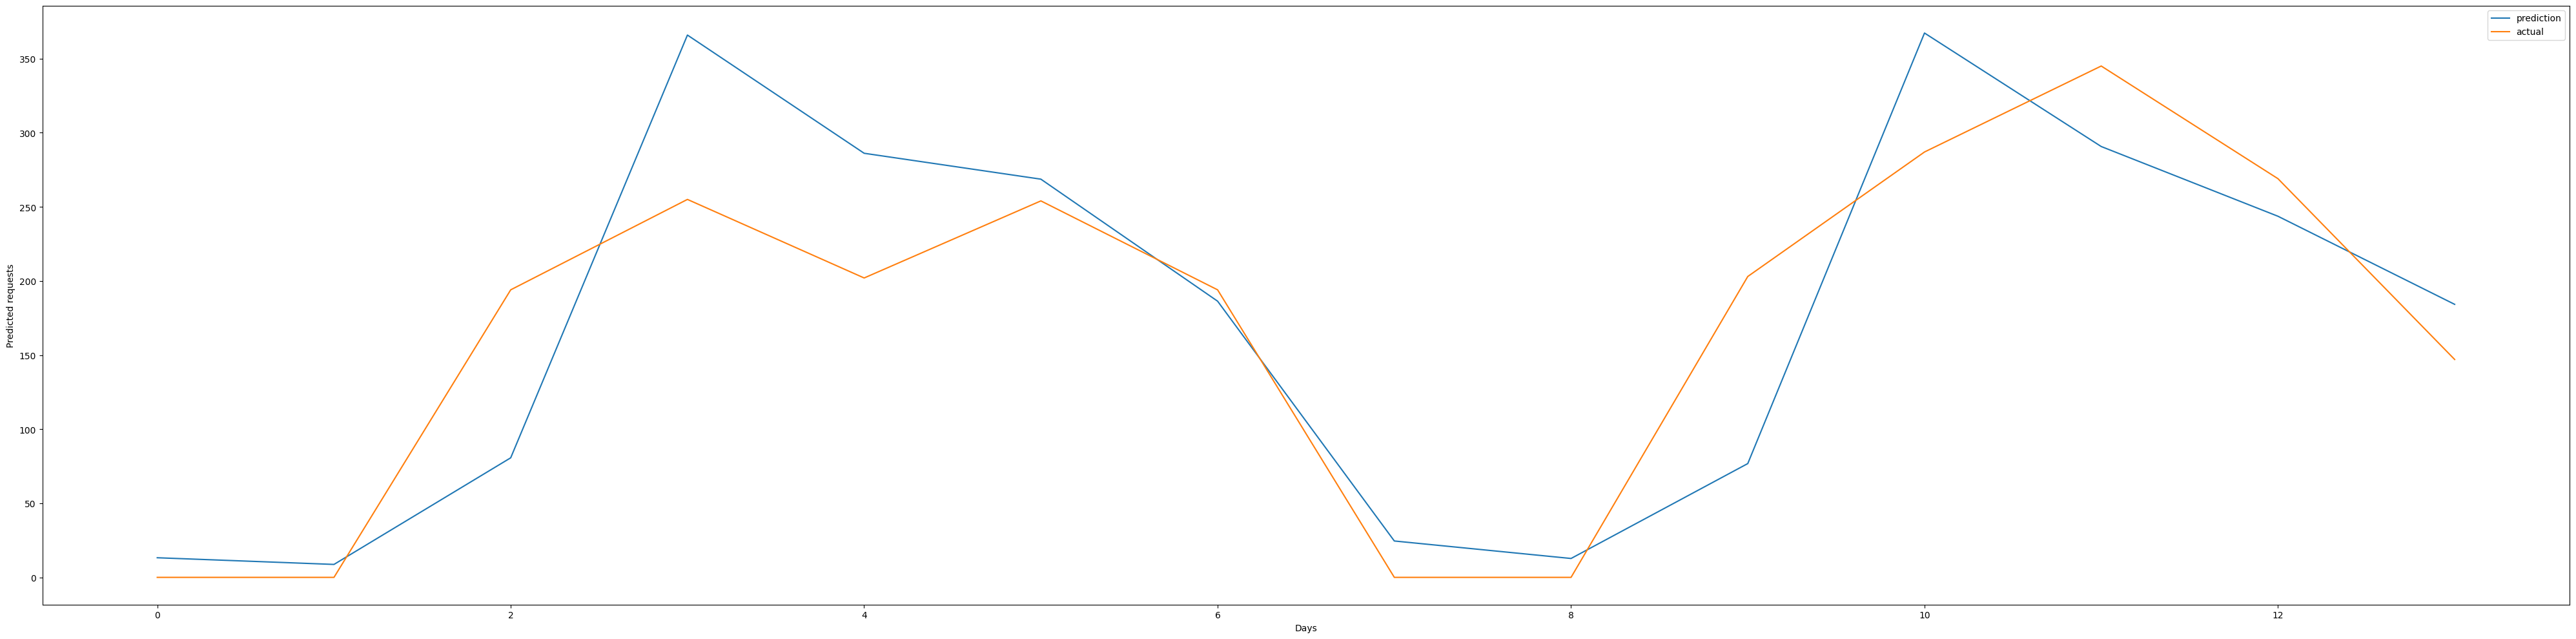

In [ ]:
# model output plot
plt.figure(figsize=(40,10))
plt.plot(record_pred_lgbm)
plt.plot(y_test.values)
plt.legend(['prediction', 'actual'])
plt.xlabel('Days')
plt.ylabel('Predicted requests')

In [ ]:
# output dataframe generating
result_lgbm = pd.concat([y_test.reset_index(), pd.Series(record_pred_lgbm, name='Predictions')], axis=1)
result_lgbm['Predictions'] = result_lgbm['Predictions'].apply(lambda x:math.floor(x))
result_lgbm.set_index('Date', inplace=True)
result_lgbm = pd.concat([test, result_lgbm], axis=1)

# Feature Importance generation

In [ ]:
feature_importances = grid_search_rf.best_estimator_.feature_importances_

In [ ]:
rf_fi = pd.DataFrame({'Features': X_train.columns,
                        'Importances': (np.round(feature_importances/sum(feature_importances)*100,2))})

In [ ]:
rf_fi

,Features,Importances
0,holiday,11.49
1,day_of_week_0,7.32
2,day_of_week_1,2.91
3,day_of_week_2,2.58
4,day_of_week_3,1.54
5,day_of_week_4,3.61
6,day_of_week_5,4.88
7,day_of_week_6,6.02
8,month_1,1.48
9,month_2,1.44


# Confidence Interval

In [ ]:
# generating standard error
residuals = y_test - record_pred_rf
std_error = np.std(residuals) / np.sqrt(len(y_test))

In [ ]:
std_error

11.616655392857249

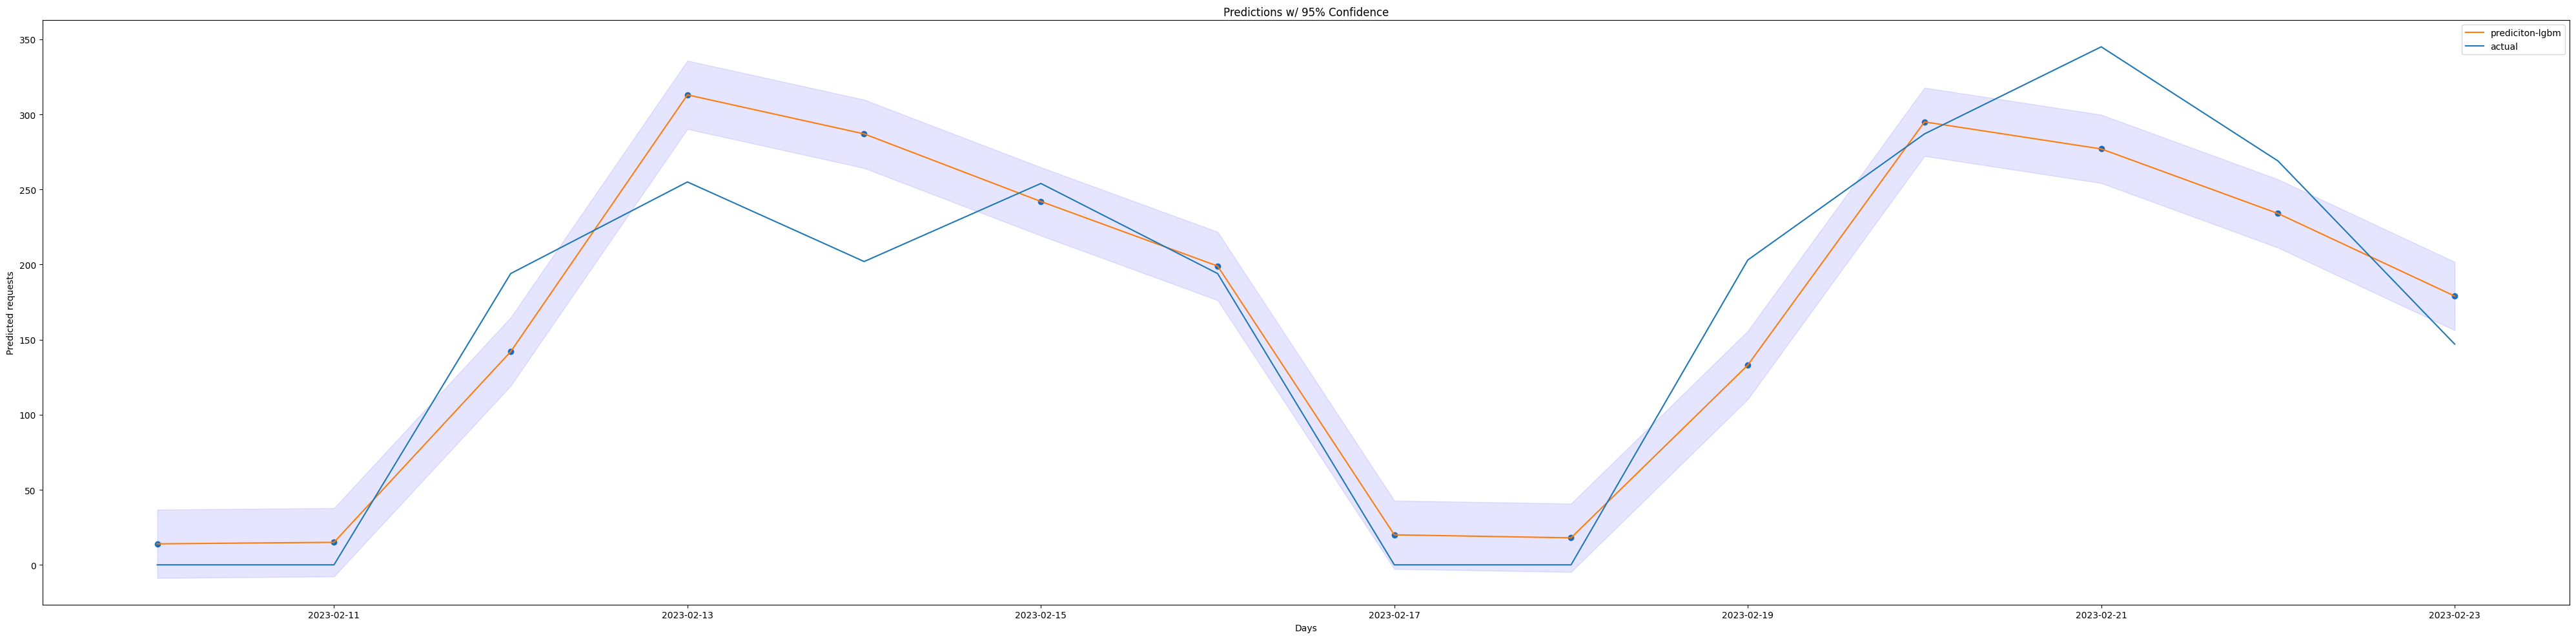

In [ ]:
# plotting Confidence interval graph with a 95% confidence band
band_size = 1.96*std_error

fig, ax = plt.subplots(figsize=(40,10))
ax.plot(result_rf.index, result_rf['Predictions'], color='#fc7d0b')
ax.plot(result_rf.index, y_test)
ax.scatter(result_rf.index, result_rf['Predictions'])
ax.fill_between(result_rf.index, (result_rf['Predictions']-band_size), (result_rf['Predictions']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
plt.xlabel('Days')
plt.ylabel('Predicted requests')
plt.legend(['prediciton', 'actual'])
plt.show()

# Error Measures

In [ ]:
print("HW: ", mape(y_test.values, prediction_hw))
print("RR: ",mape(y_test.values, record_pred_rr))
print("LR: ",mape(y_test.values, record_pred_lr))
print("RF: ",mape(y_test.values, record_pred_rf))
print("LGBM: ",mape(y_test.values, record_pred_lgbm))

HW:  22.33
RR:  21.0
LR:  23.67
RF:  19.12
LGBM:  29.39


In [ ]:
print("HW: ", bias(y_test.values, prediction_hw))
print("RR: ", bias(y_test.values, record_pred_rr))
print("LR: ", bias(y_test.values, record_pred_lr))
print("RF: ", bias(y_test.values, record_pred_rf))
print("LGBM: ", bias(y_test.values, record_pred_lgbm))

HW:  77.67
RR:  94.67
LR:  95.49
RF:  99.63
LGBM:  99.45


# Hierarchical Forecasting

In [ ]:
# Select required columns and rows
prof_weight = prof_detail.loc[(prof_detail['Date'] >= '2023-01-13') & (prof_detail['Date'] <= '2023-02-10'),
                              ['Date','Matiere','Service']].groupby(['Date','Matiere','Service']).size().reset_index(name='Record_count')
# Filter dataframe to relevant matieres and remove rows with N/A and -
relevant_matiere = ['anglais', 'chimie', 'education_financiere', 'francais', 'geo_histoire', 'geographie', 'histoire', 'math', 'math_1_2', 'math_3_5', 'monde_contemporain', 'physique', 'sciences']
####Daily Call Demand####
relevant_service = ['Call']
weight_weekly_call = prof_weight[(prof_weight['Matiere'].isin(relevant_matiere)) & (prof_weight['Service'].isin(relevant_service)) & (prof_weight['Matiere'] != 'N/A') & (prof_weight['Matiere'] != '-')]
# Calculate the weight of each subject and langue preference
weight_call = weight_weekly_call.groupby(['Date','Matiere'])['Record_count'].sum() / weight_weekly_call.groupby(['Date'])['Record_count'].sum()
# convert the series to a DataFrame, change the col name to 'weight_pct'
call_df = weight_call.to_frame()
call_df.reset_index(inplace=True)
call_df = call_df.rename(columns={'Record_count': 'weight_pct'})
call_df = call_df.groupby(['Matiere']).mean()
# Group the results in 'result_rf' dataset by week using 'pd.Grouper()' function and calculate the sum of predictions for each week
rf_weekly = result_rf.groupby(pd.Grouper(freq='W-FRI')).sum().reset_index()
# Select only the 'Date' and 'Predictions' columns from the resulting dataset
rf_weekly = rf_weekly[['Date', 'Predictions']]
rf_weekly = rf_weekly.drop(rf_weekly.index[0])
# Repeat the predictions values for each row in grouped_weight
call_df_replicated = pd.concat([call_df]*2)
call_df_replicated.loc[0:6, 'Date'] = '2023-02-17'
call_df_replicated.loc[6:12, 'Date'] = '2023-02-24'
# Calculate the weighted predictions by multiplying 'Predictions' and 'Record_count' columns and store them in a new column 'Weighted_Predictions'
# Convert the Date column in weight_df_replicated to datetime format
call_df_replicated['Date'] = pd.to_datetime(call_df_replicated['Date'])
call_df_replicated = call_df_replicated.reset_index()
merged_call = pd.merge(rf_weekly, call_df_replicated, on='Date')
merged_call['Weighted_Predictions'] = merged_call['Predictions'] * merged_call['weight_pct']
# Add col[Weighted_Predictions] into weight_df, convert the 'Weighted_Predictions' column in 'weight_df' dataset to integer type
# Add week as index of the output table
call_result = pd.merge(call_df_replicated, merged_call[['Date', 'Matiere', 'Weighted_Predictions']], on=['Date', 'Matiere'])
call_result['Weighted_Predictions'] = call_result['Weighted_Predictions'].astype(int)
call_result['week'] = call_result['Date'].dt.week
call_result = call_result.set_index('week')
call_result

,Matiere,weight_pct,Date,Weighted_Predictions
week,,,,
7,anglais,0.020456,2023-02-17,24
7,francais,0.072224,2023-02-17,87
7,geo_histoire,0.061422,2023-02-17,74
7,math_1_2,0.213989,2023-02-17,260
7,math_3_5,0.371151,2023-02-17,452
7,sciences,0.278693,2023-02-17,339
8,anglais,0.020456,2023-02-24,23
8,francais,0.072224,2023-02-24,82
8,geo_histoire,0.061422,2023-02-24,69


In [ ]:
call_result['Weighted_Predictions']

week
7     24
7     87
7     74
7    260
7    452
7    339
8     23
8     82
8     69
8    243
8    421
8    316
Name: Weighted_Predictions, dtype: int64

In [ ]:
call_result.reset_index(inplace=True)

In [ ]:
# Calculate RMSE, MAPE and Bias for hierarchical forecasting Method
# Exrtract actual demand data from result_rf
actual_demand = result_rf.groupby(pd.Grouper(freq='W-FRI')).sum().reset_index()
actual_demand = actual_demand[['Date', 'Record_count']]
actual_demand['week'] = actual_demand['Date'].dt.week
actual_demand = actual_demand.drop(0)
actual_demand = actual_demand.set_index('week')
# Calculate actual weight of demand during 2022-02-10 to 2022-02-24
actual_weight = prof_detail.loc[(prof_detail['Date'] >= '2023-02-10') & (prof_detail['Date'] <= '2023-02-24'),
                              ['Date','Matiere','Service']].groupby(['Date','Matiere','Service']).size().reset_index(name='Record_count')
# Filter dataframe to relevant matieres and remove rows with N/A and -
relevant_matiere = ['anglais','francais', 'geo_histoire', 'math_1_2', 'math_3_5','sciences']
####Daily Call Demand####
relevant_service = ['Call']
weight = actual_weight[(actual_weight['Matiere'].isin(relevant_matiere)) & (actual_weight['Service'].isin(relevant_service)) & (actual_weight['Matiere'] != 'N/A') & (actual_weight['Matiere'] != '-')]
# Calculate the weight of each subject and langue preference
actual_weight_call = weight.groupby(['Date','Matiere'])['Record_count'].sum() / weight.groupby(['Date'])['Record_count'].sum()
# convert the series to a DataFrame, change the col name to 'weight_pct'
actual_df = actual_weight_call.to_frame()
actual_df.reset_index(inplace=True)
actual_df = actual_df.rename(columns={'Record_count': 'weight_pct'})
actual_df = actual_df.groupby(['Matiere']).mean()
# Calculate the actual_d values
actual_d = actual_demand['Record_count'].values[:, None] * actual_df['weight_pct'].values
# Create a MultiIndex DataFrame with week and Matiere as indices
multi_index = pd.MultiIndex.from_product([actual_demand.index, actual_df.index], names=['week', 'Matiere'])
# Create the new DataFrame with actual_d values
actual_result = pd.DataFrame(actual_d.flatten(), index=multi_index, columns=['actual_demand'])
actual_result = actual_result.reset_index()
call_result = call_result.reset_index()
# Merge call_result_reset with actual_demand_result_reset on the columns 'week' and 'Matiere'
call_result = call_result.merge(actual_result, on=['week', 'Matiere'], how='left')
# Set the index back to 'week' in the merged DataFrame
call_result = call_result.set_index('week')
# RMSE
# Calculate the squared differences between the two columns
call_result['squared_diff'] = (call_result['Weighted_Predictions'] - call_result['actual_demand']) ** 2
# Group by 'Matiere' and calculate the mean of squared differences for each group
mean_squared_diff_grouped = call_result.groupby('Matiere')['squared_diff'].mean()
# Calculate the RMSE for each group (square root of the mean squared differences)
rmse_grouped = np.sqrt(mean_squared_diff_grouped)
# Create a DataFrame from the RMSE series
accuracy_df = rmse_grouped.reset_index()
accuracy_df.columns = ['Matiere', 'RMSE']
# Drop the squared_diff column, as it is no longer needed
call_result = call_result.drop(columns=['squared_diff'])
# MAPE
# Calculate the absolute percentage error between the two columns
call_result['abs_pct_error'] = abs((call_result['Weighted_Predictions'] - call_result['actual_demand']) / call_result['actual_demand']) * 100
# Group by 'Matiere' and calculate the mean of absolute percentage errors for each group
mean_abs_pct_error_grouped = call_result.groupby('Matiere')['abs_pct_error'].mean()
# Update the rmse_df DataFrame with the new MAPE column
accuracy_df['MAPE'] = mean_abs_pct_error_grouped.reset_index(drop=True)
# Bias
# Calculate the bias between the two columns
call_result['bias'] = call_result['Weighted_Predictions'] / call_result['actual_demand']
# Group by 'Matiere' and calculate the mean of biases for each group
mean_bias_grouped = call_result.groupby('Matiere')['bias'].mean()
# Update the rmse_df DataFrame with the new Bias column
accuracy_df['Bias'] = mean_bias_grouped.reset_index(drop=True)
# Overall Accuracy
# Calculate the mean of each column and store it in a new DataFrame
mean_values = accuracy_df.mean().to_frame().transpose()
# Add the mean values to the original DataFrame
accuracy_df = pd.concat([accuracy_df, mean_values], ignore_index=True)
# Set the 'Matiere' value for the last row to 'average'
accuracy_df.loc[accuracy_df.index[-1], 'Matiere'] = 'average'
accuracy_df

,Matiere,RMSE,MAPE,Bias
0,anglais,2.356908,8.249683,0.961061
1,francais,33.420914,26.949147,0.730509
2,geo_histoire,29.123158,67.909708,1.679097
3,math_1_2,29.985302,9.320413,0.948515
4,math_3_5,45.606204,9.827109,0.983094
5,sciences,37.529413,10.695292,1.074157
6,average,29.670316,22.158559,1.062739


# KPI Input measurements

In [ ]:
pd2=prof_detail.copy()

In [ ]:
pd2.dtypes

Conversation_ID            object
Date               datetime64[ns]
Time               datetime64[ns]
Agent                      object
Service                    object
Direction                  object
Langue                     object
Niveau                     object
Matiere                    object
temps_comm                  int64
temps_attente             float64
dtype: object

In [ ]:
service_subject_time = pd2.groupby([pd2['Service'],pd2['Matiere']])['temps_comm'].mean()/60

In [ ]:
service_subject_time_t=service_subject_time.T

In [ ]:
# Average call time per subject
service_subject_time['Call']

Matiere
N/A                     10.368721
anglais                  9.415188
autre                    7.404382
chimie                  10.594180
education_financiere     1.509195
francais                 8.640387
geo_histoire             9.577258
geographie               6.760256
histoire                10.962931
math                    12.045847
math_1_2                10.830224
math_3_5                11.600682
monde_contemporain       2.928205
physique                12.553776
sciences                12.124512
Name: temps_comm, dtype: float64

In [ ]:
service_subject_wait = pd2.groupby([pd2['Service'],pd2['Matiere']])['temps_attente'].mean()/60

In [ ]:
# Average wait time by subject
service_subject_wait['Call']

Matiere
N/A                     0.755907
anglais                 1.060978
autre                   0.855747
chimie                  0.963228
education_financiere    0.470690
francais                0.771336
geo_histoire            0.507209
geographie              0.293590
histoire                0.673276
math                    1.165908
math_1_2                0.545557
math_3_5                0.822973
monde_contemporain      0.325641
physique                0.673307
sciences                0.706091
Name: temps_attente, dtype: float64

# Erlang C

In [ ]:
subject_req=pd.merge(call_result,service_subject_time['Call'], on='Matiere')

In [ ]:
subject_req

,week,Matiere,weight_pct,Date,Weighted_Predictions,temps_comm
0,7,anglais,0.020456,2023-02-17,24,9.415188
1,8,anglais,0.020456,2023-02-24,23,9.415188
2,7,francais,0.072224,2023-02-17,87,8.640387
3,8,francais,0.072224,2023-02-24,82,8.640387
4,7,geo_histoire,0.061422,2023-02-17,74,9.577258
5,8,geo_histoire,0.061422,2023-02-24,69,9.577258
6,7,math_1_2,0.213989,2023-02-17,260,10.830224
7,8,math_1_2,0.213989,2023-02-24,243,10.830224
8,7,math_3_5,0.371151,2023-02-17,452,11.600682
9,8,math_3_5,0.371151,2023-02-24,421,11.600682


In [ ]:
subject_req=pd.merge(subject_req,service_subject_wait['Call'], on='Matiere')

In [ ]:
# dataframe with subject and week level predictions and average call and wait times
subject_req

,week,Matiere,weight_pct,Date,Weighted_Predictions,temps_comm,temps_attente
0,7,anglais,0.020456,2023-02-17,24,9.415188,1.060978
1,8,anglais,0.020456,2023-02-24,23,9.415188,1.060978
2,7,francais,0.072224,2023-02-17,87,8.640387,0.771336
3,8,francais,0.072224,2023-02-24,82,8.640387,0.771336
4,7,geo_histoire,0.061422,2023-02-17,74,9.577258,0.507209
5,8,geo_histoire,0.061422,2023-02-24,69,9.577258,0.507209
6,7,math_1_2,0.213989,2023-02-17,260,10.830224,0.545557
7,8,math_1_2,0.213989,2023-02-24,243,10.830224,0.545557
8,7,math_3_5,0.371151,2023-02-17,452,11.600682,0.822973
9,8,math_3_5,0.371151,2023-02-24,421,11.600682,0.822973


In [ ]:
# Using Erlang C to predict agent requirements
result = {}
for index, row in subject_req.iterrows():
    erlang = ErlangC(transactions=row['Weighted_Predictions'], asa=row['temps_attente'], aht=row['temps_comm'], interval=2400, shrinkage=0.3)
    requirements = erlang.required_positions(service_level=0.9,max_occupancy=0.9)
    result[index] = requirements
    # print('The number of agents needed for ',row['Matiere'], ' for week ',row['week'], requirements)
result = pd.concat([subject_req, pd.DataFrame(result).transpose()], axis=1)

In [ ]:
result

,week,Matiere,weight_pct,Date,Weighted_Predictions,temps_comm,temps_attente,raw_positions,positions,service_level,occupancy,waiting_probability
0,7,anglais,0.020456,2023-02-17,24,9.415188,1.060978,1.0,2.0,0.914985,0.094152,0.094152
1,8,anglais,0.020456,2023-02-24,23,9.415188,1.060978,1.0,2.0,0.918563,0.090229,0.090229
2,7,francais,0.072224,2023-02-17,87,8.640387,0.771336,2.0,3.0,0.963519,0.156607,0.042410
3,8,francais,0.072224,2023-02-24,82,8.640387,0.771336,2.0,3.0,0.967390,0.147607,0.037971
4,7,geo_histoire,0.061422,2023-02-17,74,9.577258,0.507209,2.0,3.0,0.965288,0.147649,0.037991
5,8,geo_histoire,0.061422,2023-02-24,69,9.577258,0.507209,2.0,3.0,0.969588,0.137673,0.033320
6,7,math_1_2,0.213989,2023-02-17,260,10.830224,0.545557,4.0,6.0,0.970115,0.293319,0.034458
7,8,math_1_2,0.213989,2023-02-24,243,10.830224,0.545557,4.0,6.0,0.976103,0.274140,0.027661
8,7,math_3_5,0.371151,2023-02-17,452,11.600682,0.822973,5.0,8.0,0.932925,0.436959,0.081902
9,8,math_3_5,0.371151,2023-02-24,421,11.600682,0.822973,5.0,8.0,0.948495,0.406991,0.063563


In [ ]:
# result generation
result.to_csv('Staffing.csv')
files.download('Staffing.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>